# Project 4: Predicting Boxing Match Outcomes using Machine Learning

*This notebook details the process of preparing data, training several machine learning models, and evaluating their performance to predict the winner of professional boxing matches from the original Kaggle dataset. It focuses on handling class imbalance and identifying key predictive features.*

## 1. Setup: Importing Libraries & Mounting Drive
Importing necessary Python libraries and mounting Google Drive to access the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb # Or from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Data Loading & Initial Cleaning

### 2.1 Data Loading
Loading the `boxing_matches.csv` dataset from the specified Google Drive path.

In [2]:
try:
    file_path = '/content/drive/MyDrive/Colab Notebooks/boxing_matches.csv'
    df = pd.read_csv(file_path)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print("First 5 rows:")
    display(df.head())
except FileNotFoundError:

    print(f"Error: File not found at {file_path}. Please verify the path.")
    df = None
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    df = None
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print("First 5 rows:")
    display(df.head())
except FileNotFoundError:

    print(f"Error: File not found at {file_path}. Please verify the path.")
    df = None
except pd.errors.ParserError:
    print("Error: Unable to parse the CSV file. Please check the file format.")
    df = None
except Exception as e:
    print(f"An unexpected error occurred during loading: {e}")
    df = None

Dataset loaded successfully. Shape: (387427, 26)
First 5 rows:


,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,...,kos_A,kos_B,result,decision,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,...,33,34.0,draw,SD,110.0,118.0,115.0,113.0,114.0,114.0
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,...,34,32.0,win_A,UD,120.0,108.0,120.0,108.0,120.0,108.0
2,28.0,26.0,176.0,175.0,NaN,179.0,orthodox,orthodox,154.0,154.0,...,13,33.0,win_B,KO,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,...,32,19.0,win_A,KO,47.0,48.0,49.0,46.0,48.0,47.0
4,25.0,35.0,175.0,170.0,179.0,170.0,orthodox,orthodox,155.0,NaN,...,32,33.0,win_A,UD,118.0,110.0,119.0,109.0,117.0,111.0


### 2.2 Initial Outlier Capping
Based on insights from Project 1 (EDA), initial outlier capping is applied to physical attribute columns (age, height, weight, reach) to ensure values fall within realistic ranges.

In [3]:
if df is not None:
    capping_ranges = {
        'age_A': (16, 50), 'age_B': (16, 50),
        'height_A': (150, 210), 'height_B': (150, 210),
        'weight_A': (100, 250), 'weight_B': (100, 250),
        'reach_A': (150, 220), 'reach_B': (150, 220)
    }
    print("Applying outlier capping...")
    for col, (min_val, max_val) in capping_ranges.items():
        if col in df.columns:
            df[col] = np.clip(df[col], min_val, max_val)
    print("Outlier capping complete.")
    print("\nFirst 5 rows after capping:")
    display(df.head())

Applying outlier capping...
Outlier capping complete.

First 5 rows after capping:


,age_A,age_B,height_A,height_B,reach_A,reach_B,stance_A,stance_B,weight_A,weight_B,...,kos_A,kos_B,result,decision,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
0,35.0,27.0,179.0,175.0,178.0,179.0,orthodox,orthodox,160.0,160.0,...,33,34.0,draw,SD,110.0,118.0,115.0,113.0,114.0,114.0
1,26.0,31.0,175.0,185.0,179.0,185.0,orthodox,orthodox,164.0,164.0,...,34,32.0,win_A,UD,120.0,108.0,120.0,108.0,120.0,108.0
2,28.0,26.0,176.0,175.0,NaN,179.0,orthodox,orthodox,154.0,154.0,...,13,33.0,win_B,KO,NaN,NaN,NaN,NaN,NaN,NaN
3,25.0,29.0,175.0,174.0,179.0,180.0,orthodox,orthodox,155.0,155.0,...,32,19.0,win_A,KO,47.0,48.0,49.0,46.0,48.0,47.0
4,25.0,35.0,175.0,170.0,179.0,170.0,orthodox,orthodox,155.0,NaN,...,32,33.0,win_A,UD,118.0,110.0,119.0,109.0,117.0,111.0


### 2.3 Initial Exploration of Capped Data
Performing initial exploration on the capped DataFrame to understand its structure, data types, summary statistics, and missing value counts. This provides a baseline before further preparation for modeling.

In [4]:
if df is not None:
    print("--- Data Info ---")
    df.info()

    print("\n--- Descriptive Statistics (Numerical, After Capping) ---")
    display(df.describe())

    print("\n--- Missing Value Counts (After Capping) ---")
    print(df.isnull().sum())

    print("\n--- Value Counts for Key Categorical Columns ---")
    if 'decision' in df.columns:
        print("\nDecision Types:\n", df['decision'].value_counts())
    if 'result' in df.columns:
        print("\nResult Types:\n", df['result'].value_counts())
    if 'stance_A' in df.columns:
        print("\nStance_A Counts:\n", df['stance_A'].value_counts())

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387427 entries, 0 to 387426
Data columns (total 26 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   age_A     352888 non-null  float64
 1   age_B     257935 non-null  float64
 2   height_A  249246 non-null  float64
 3   height_B  134640 non-null  float64
 4   reach_A   112342 non-null  float64
 5   reach_B   37873 non-null   float64
 6   stance_A  231009 non-null  object 
 7   stance_B  231009 non-null  object 
 8   weight_A  135573 non-null  float64
 9   weight_B  130358 non-null  float64
 10  won_A     387427 non-null  int64  
 11  won_B     387427 non-null  int64  
 12  lost_A    387427 non-null  int64  
 13  lost_B    387427 non-null  int64  
 14  drawn_A   387427 non-null  int64  
 15  drawn_B   387427 non-null  int64  
 16  kos_A     387427 non-null  int64  
 17  kos_B     387348 non-null  float64
 18  result    387427 non-null  object 
 19  decision  387427 non-null 

,age_A,age_B,height_A,height_B,reach_A,reach_B,weight_A,weight_B,won_A,won_B,...,drawn_A,drawn_B,kos_A,kos_B,judge1_A,judge1_B,judge2_A,judge2_B,judge3_A,judge3_B
count,352888.000000,257935.000000,249246.000000,134640.000000,112342.000000,37873.000000,135573.000000,130358.000000,387427.000000,387427.000000,...,387427.000000,387427.000000,387427.000000,387348.000000,52248.000000,52060.000000,70371.000000,70032.000000,61231.000000,61023.000000
mean,24.413667,26.524411,172.805040,172.934685,178.891999,179.149764,146.233490,146.903980,23.108438,15.159080,...,2.826481,2.636375,10.338887,6.234735,62.778901,59.509700,59.560941,56.570411,60.784276,57.995215
std,4.899291,5.227438,8.934495,8.889615,11.216685,11.644283,29.741952,29.773481,27.629901,19.938137,...,5.584610,5.027003,12.392049,8.750690,30.337580,29.285058,31.021367,30.260935,31.910461,31.170590
min,16.000000,16.000000,150.000000,150.000000,150.000000,150.000000,100.000000,100.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,21.000000,23.000000,166.000000,167.000000,170.000000,171.000000,125.000000,126.000000,5.000000,2.000000,...,0.000000,0.000000,2.000000,0.000000,39.000000,37.000000,39.000000,36.000000,39.000000,36.000000
50%,24.000000,26.000000,173.000000,173.000000,178.000000,178.000000,140.000000,140.000000,14.000000,8.000000,...,1.000000,1.000000,6.000000,3.000000,59.000000,54.000000,58.000000,54.000000,58.000000,54.000000
75%,27.000000,30.000000,178.000000,179.000000,185.000000,185.000000,160.000000,160.000000,31.000000,21.000000,...,3.000000,3.000000,14.000000,9.000000,80.000000,79.000000,80.000000,75.000000,80.000000,78.000000
max,50.000000,50.000000,210.000000,210.000000,220.000000,220.000000,250.000000,250.000000,332.000000,251.000000,...,77.000000,76.000000,131.000000,128.000000,540.000000,291.000000,299.000000,294.000000,300.000000,295.000000



--- Missing Value Counts (After Capping) ---
age_A        34539
age_B       129492
height_A    138181
height_B    252787
reach_A     275085
reach_B     349554
stance_A    156418
stance_B    156418
weight_A    251854
weight_B    257069
won_A            0
won_B            0
lost_A           0
lost_B           0
drawn_A          0
drawn_B          0
kos_A            0
kos_B           79
result           0
decision         0
judge1_A    335179
judge1_B    335367
judge2_A    317056
judge2_B    317395
judge3_A    326196
judge3_B    326404
dtype: int64

--- Value Counts for Key Categorical Columns ---

Decision Types:
 decision
PTS    108070
TKO     89709
KO      70940
UD      62290
NWS     19369
SD      11323
MD       9364
RTD      9065
DQ       4831
TD       2466
Name: count, dtype: int64

Result Types:
 result
win_A    321661
win_B     40994
draw      24772
Name: count, dtype: int64

Stance_A Counts:
 stance_A
orthodox    190232
southpaw     40777
Name: count, dtype: int64


## 3. Data Preparation & Feature Engineering for Modeling

This section details the further steps taken to prepare the dataset for machine learning: creating the target variable, selecting and engineering features, and handling missing values within the feature set.

### 3.1 Target Variable Creation
Matches resulting in a 'draw' are filtered out to focus on decisive outcomes. A binary target variable (`target`, assigned to `y`) is then created, where 'Win A' is mapped to 1 and 'Win B' is mapped to 0.

In [5]:
# --- Step 1: Create Binary Target Variable ---
print("Starting Step 1: Create Binary Target Variable...")
if 'df' in locals() and df is not None:
    # Filter out draws and create a copy to avoid warnings
    df_model = df[df['result'] != 'draw'].copy()
    print(f"Shape after removing draws: {df_model.shape}")

    # Create binary target: 1 if win_A, 0 if win_B
    df_model['target'] = df_model['result'].apply(lambda x: 1 if x == 'win_A' else 0)

    # Assign target variable 'y'
    y = df_model['target']

    # Check distribution
    print("\nTarget variable 'y' created.")
    print("Target variable distribution (%):")
    print(y.value_counts(normalize=True) * 100)
else:
    print("Error: DataFrame 'df' not found or is None. Please load data and cap outliers first.")
    # Stop execution if df doesn't exist
    raise ValueError("DataFrame 'df' is not available.")
print("-" * 30)

Starting Step 1: Create Binary Target Variable...
Shape after removing draws: (362655, 26)

Target variable 'y' created.
Target variable distribution (%):
target
1    88.696144
0    11.303856
Name: proportion, dtype: float64
------------------------------


### 3.2 Feature Selection & Engineering
An initial set of pre-fight features (age, records, KOs for both competitors) is selected. To capture comparative attributes, difference-based features (e.g., age difference, win difference) are engineered and added to the feature set `X`.

In [6]:
# --- Step 2: Select Initial Features & Engineer Differences ---
print("Starting Step 2: Select Features & Engineer Differences...")
if 'df_model' in locals() and y is not None:
    # Define initial feature columns
    feature_cols = [
        'age_A', 'age_B',
        'won_A', 'won_B',
        'losses_A', 'losses_B', # Make sure 'losses_A'/'losses_B' is the correct renamed column name
        'drawn_A', 'drawn_B',
        'kos_A', 'kos_B'
    ]
    # Ensure columns exist before selecting
    feature_cols = [col for col in feature_cols if col in df_model.columns]

    X = df_model[feature_cols].copy() # Create base feature DataFrame
    print(f"Selected initial features ({len(feature_cols)}): {feature_cols}")

    # Engineer difference features
    print("Engineering difference features...")
    if 'age_A' in X.columns and 'age_B' in X.columns:
        X['age_diff'] = X['age_A'] - X['age_B']
    if 'won_A' in X.columns and 'won_B' in X.columns:
        X['win_diff'] = X['won_A'] - X['won_B']
    if 'losses_A' in X.columns and 'losses_B' in X.columns:
        X['loss_diff'] = X['losses_A'] - X['losses_B']
    if 'kos_A' in X.columns and 'kos_B' in X.columns:
        X['ko_diff'] = X['kos_A'] - X['kos_B']
    if all(c in X.columns for c in ['won_A', 'losses_A', 'drawn_A', 'won_B', 'losses_B', 'drawn_B']):
         X['exp_diff'] = (X['won_A'] + X['losses_A'] + X['drawn_A']) - \
                         (X['won_B'] + X['losses_B'] + X['drawn_B'])

    print("Current features in X:")
    print(X.columns.tolist())
    display(X.head())
else:
    print("Error: 'df_model' or 'y' not available. Ensure Step 1 ran correctly.")
    raise ValueError("'df_model' or 'y' is not available.")
print("-" * 30)

Starting Step 2: Select Features & Engineer Differences...
Selected initial features (8): ['age_A', 'age_B', 'won_A', 'won_B', 'drawn_A', 'drawn_B', 'kos_A', 'kos_B']
Engineering difference features...
Current features in X:
['age_A', 'age_B', 'won_A', 'won_B', 'drawn_A', 'drawn_B', 'kos_A', 'kos_B', 'age_diff', 'win_diff', 'ko_diff']


,age_A,age_B,won_A,won_B,drawn_A,drawn_B,kos_A,kos_B,age_diff,win_diff,ko_diff
1,26.0,31.0,48,50,1,1,34,32.0,-5.0,-2,2.0
2,28.0,26.0,23,47,1,1,13,33.0,2.0,-24,-20.0
3,25.0,29.0,46,31,1,0,32,19.0,-4.0,15,13.0
4,25.0,35.0,45,40,1,0,32,33.0,-10.0,5,-1.0
5,24.0,31.0,44,32,1,0,31,28.0,-7.0,12,3.0


------------------------------


### 3.3 Missing Value Imputation
Missing values remaining within the selected feature set `X` (specifically for `age_A`, `age_B`, and `kos_B`) are handled using median imputation. Difference features dependent on these imputed columns (`age_diff`, `ko_diff`) are then recalculated.

In [7]:
# --- Step 3: Impute Missing Values in Feature Set X ---
print("Starting Step 3: Impute Missing Values...")
if 'X' in locals():
    imputed_cols = []
    # Impute missing age_A
    if 'age_A' in X.columns and X['age_A'].isnull().any():
        median_age_a = X['age_A'].median()
        X['age_A'].fillna(median_age_a, inplace=True)
        imputed_cols.append(f'age_A (median={median_age_a:.2f})')

    # Impute missing age_B
    if 'age_B' in X.columns and X['age_B'].isnull().any():
        median_age_b = X['age_B'].median()
        X['age_B'].fillna(median_age_b, inplace=True)
        imputed_cols.append(f'age_B (median={median_age_b:.2f})')

    # Impute missing kos_B
    if 'kos_B' in X.columns and X['kos_B'].isnull().any():
        median_kos_b = X['kos_B'].median()
        X['kos_B'].fillna(median_kos_b, inplace=True)
        imputed_cols.append(f'kos_B (median={median_kos_b:.0f})')

    print(f"Imputed NaNs in columns: {imputed_cols if imputed_cols else 'None needed'}")

    # Recalculate difference features AFTER imputation
    print("Recalculating difference features post-imputation...")
    if 'age_diff' in X.columns and 'age_A' in X.columns and 'age_B' in X.columns:
        X['age_diff'] = X['age_A'] - X['age_B']
        print("Recalculated 'age_diff'.")
    if 'ko_diff' in X.columns and 'kos_A' in X.columns and 'kos_B' in X.columns:
        X['ko_diff'] = X['kos_A'] - X['kos_B']
        print("Recalculated 'ko_diff'.")

    # Final Check for NaNs in X
    remaining_nans = X.isnull().sum().sum()
    print(f"\nTotal remaining NaNs in feature set X: {remaining_nans}")
    if remaining_nans > 0:
        print("ERROR: NaNs still present! Columns with NaNs:")
        print(X.isnull().sum()[X.isnull().sum() > 0])
        raise ValueError("NaNs remain in feature set X after imputation.")
    else:
        print("Feature set X confirmed free of NaNs.")
else:
    print("Error: Feature DataFrame 'X' not found. Ensure Step 2 ran correctly.")
    raise ValueError("DataFrame 'X' is not available.")
print("-" * 30)

Starting Step 3: Impute Missing Values...
Imputed NaNs in columns: ['age_A (median=24.00)', 'age_B (median=26.00)', 'kos_B (median=3)']
Recalculating difference features post-imputation...
Recalculated 'age_diff'.
Recalculated 'ko_diff'.

Total remaining NaNs in feature set X: 0
Feature set X confirmed free of NaNs.
------------------------------


<ipython-input-7-815b3a43efb0>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['age_A'].fillna(median_age_a, inplace=True)
<ipython-input-7-815b3a43efb0>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

### 3.4 Train/Test Split
The prepared features (`X`) and target (`y`) are split into training (80%) and testing (20%) sets. Stratification is used to maintain class proportions due to the significant data imbalance.

In [8]:
# --- Step 4: Train/Test Split ---
print("Starting Step 4: Train/Test Split...")
if 'X' in locals() and 'y' in locals():
    from sklearn.model_selection import train_test_split

    # Using 80/20 split, stratify on y due to imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print("Performed Train/Test split (80/20 stratified).")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    # Verify stratification worked (proportions should be similar)
    print(f"y_train distribution:\n{y_train.value_counts(normalize=True)}")
    print(f"y_test distribution:\n{y_test.value_counts(normalize=True)}")
else:
    print("Error: 'X' or 'y' not available. Ensure Steps 1-3 ran correctly.")
    raise ValueError("'X' or 'y' not available for splitting.")
print("-" * 30)

Starting Step 4: Train/Test Split...
Performed Train/Test split (80/20 stratified).
X_train shape: (290124, 11)
X_test shape: (72531, 11)
y_train distribution:
target
1    0.886962
0    0.113038
Name: proportion, dtype: float64
y_test distribution:
target
1    0.886959
0    0.113041
Name: proportion, dtype: float64
------------------------------


### 3.5 Feature Scaling
All numerical features in both the training and testing sets are scaled using Scikit-learn's `StandardScaler` to standardize their range (zero mean, unit variance), which benefits many machine learning algorithms.

In [9]:
# --- Step 5: Feature Scaling ---
print("Starting Step 5: Feature Scaling...")
if 'X_train' in locals() and 'X_test' in locals():
    from sklearn.preprocessing import StandardScaler

    # Assuming all columns in X_train/X_test are numerical features to be scaled
    numerical_cols = X_train.columns

    # 1. Initialize Scaler
    scaler = StandardScaler()

    # 2. Fit scaler ONLY on training data
    scaler.fit(X_train[numerical_cols])
    print("Scaler fitted on training data.")

    # 3. Transform both training and testing data
    X_train_scaled_np = scaler.transform(X_train[numerical_cols])
    X_test_scaled_np = scaler.transform(X_test[numerical_cols])

    # 4. Convert back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled_np, index=X_train.index, columns=numerical_cols)
    X_test_scaled = pd.DataFrame(X_test_scaled_np, index=X_test.index, columns=numerical_cols)

    print("Feature scaling complete.")
    print("Scaled training data (first 5 rows):")
    display(X_train_scaled.head())
    print(f"X_train_scaled shape: {X_train_scaled.shape}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
else:
    print("Error: 'X_train' or 'X_test' not found. Ensure Step 4 ran correctly.")
    raise ValueError("'X_train' or 'X_test' not available for scaling.")
print("-" * 30)

Starting Step 5: Feature Scaling...
Scaler fitted on training data.
Feature scaling complete.
Scaled training data (first 5 rows):


,age_A,age_B,won_A,won_B,drawn_A,drawn_B,kos_A,kos_B,age_diff,win_diff,ko_diff
120528,-0.087487,-0.100557,-0.833804,-0.757878,-0.495875,-0.517464,-0.837001,-0.712537,0.003693,-0.303724,-0.334486
33315,0.339697,-0.567863,-0.761103,-0.706976,-0.495875,-0.517464,-0.837001,-0.712537,0.714900,-0.265989,-0.334486
160017,0.766882,0.600402,-0.543002,-0.401567,-0.308375,0.521484,-0.595034,-0.482296,0.181495,-0.265989,-0.254617
128122,-0.087487,0.834055,0.184003,-0.554272,0.441624,-0.517464,0.130867,-0.712537,-0.707513,0.601906,0.623936
369609,0.126105,-0.100557,-0.652053,-0.350666,-0.120875,-0.517464,-0.756345,-0.482296,0.181495,-0.416928,-0.414354


X_train_scaled shape: (290124, 11)
X_test_scaled shape: (72531, 11)
------------------------------


## 4. Model Training & Evaluation
Training and evaluating several classification models to predict fight outcomes. Given the class imbalance, evaluation focuses on metrics like AUC-ROC and Precision/Recall/F1-scores for the minority class, alongside overall accuracy.

### 4.1 Baseline: Logistic Regression (Unbalanced)

In [10]:
from sklearn.linear_model import LogisticRegression

# Check if scaled training data and target variable exist
if 'X_train_scaled' in locals() and 'y_train' in locals():
    print("Training Logistic Regression model...")

    # 1. Initialize the Logistic Regression model
    # Setting random_state for reproducibility if solver uses randomness
    log_reg_model = LogisticRegression(random_state=42)

    # 2. Train (fit) the model on the scaled training data
    log_reg_model.fit(X_train_scaled, y_train)

    print("Logistic Regression model training complete!")
    # The trained model is now stored in the 'log_reg_model' variable

else:
    print("Error: Scaled training data (X_train_scaled or y_train) not found.")
    log_reg_model = None # Ensure model variable is None if training failed

Training Logistic Regression model...
Logistic Regression model training complete!


Evaluating the UNBALANCED Logistic Regression model on the test set...

--- Results for UNBALANCED Logistic Regression ---
Accuracy: 0.8849

Confusion Matrix:
[[  138  8061]
 [  289 64043]]

Classification Report:
              precision    recall  f1-score   support

   Win B (0)       0.32      0.02      0.03      8199
   Win A (1)       0.89      1.00      0.94     64332

    accuracy                           0.88     72531
   macro avg       0.61      0.51      0.49     72531
weighted avg       0.82      0.88      0.84     72531


Area Under ROC Curve (AUC-ROC): 0.7081


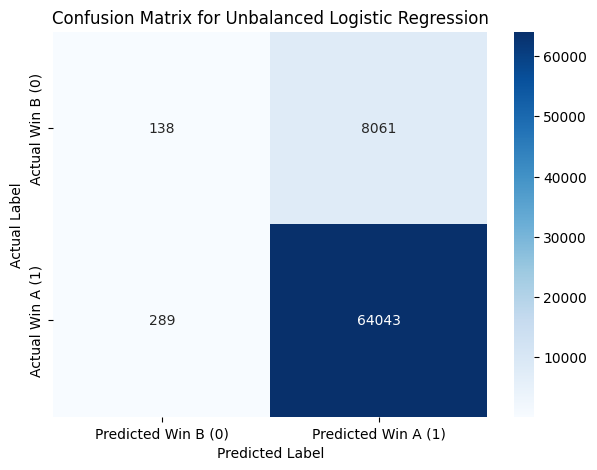

In [11]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score # Move to top later
import seaborn as sns # Move to top later
import matplotlib.pyplot as plt # Move to top later
import pandas as pd # Move to top later

# Check if model and test data exist
if 'log_reg_model' in locals() and log_reg_model is not None and \
   'X_test_scaled' in locals() and 'y_test' in locals():

    print("Evaluating the UNBALANCED Logistic Regression model on the test set...") # Clarified

    # 1. Make Predictions on Test Set
    y_pred = log_reg_model.predict(X_test_scaled)
    try:
      # Get probabilities for the positive class (1 = 'win_A') for AUC calculation
      y_pred_proba = log_reg_model.predict_proba(X_test_scaled)[:, 1]
      roc_auc = roc_auc_score(y_test, y_pred_proba)
    except Exception as e:
      print(f"Could not calculate predict_proba or ROC AUC score: {e}")
      y_pred_proba = None # Set to None if unavailable
      roc_auc = None


    # 2. Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['Win B (0)', 'Win A (1)']) # Added target names

    # 3. Print Metrics
    print(f"\n--- Results for UNBALANCED Logistic Regression ---") # Clarified
    print(f"Accuracy: {accuracy:.4f}")

    print("\nConfusion Matrix:")
    print(conf_matrix)
    # TN | FP
    # FN | TP

    print("\nClassification Report:")
    print(class_report)

    if roc_auc is not None:
        print(f"\nArea Under ROC Curve (AUC-ROC): {roc_auc:.4f}")

    # 4. Visualize Confusion Matrix
    plt.figure(figsize=(7, 5)) # Adjusted size slightly
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Win B (0)', 'Predicted Win A (1)'],
                yticklabels=['Actual Win B (0)', 'Actual Win A (1)'])
    plt.yticks(va='center') # Center y-tick labels vertically
    plt.title('Confusion Matrix for Unbalanced Logistic Regression') # Clarified title
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Error: Model or test data not found. Ensure training was successful.")

### 4.2 Balanced Logistic Regression
To directly address the class imbalance, the Logistic Regression model is retrained using the `class_weight='balanced'` parameter. This gives more weight to the minority class ('Win B') during training.

Training Logistic Regression model with class_weight='balanced'...
Balanced Logistic Regression model training complete!

Evaluating the BALANCED Logistic Regression model on the test set...

--- Results for Balanced Logistic Regression ---
Accuracy: 0.6805

Confusion Matrix:
[[ 5178  3021]
 [20150 44182]]

Classification Report:
              precision    recall  f1-score   support

   Win B (0)       0.20      0.63      0.31      8199
   Win A (1)       0.94      0.69      0.79     64332

    accuracy                           0.68     72531
   macro avg       0.57      0.66      0.55     72531
weighted avg       0.85      0.68      0.74     72531


Area Under ROC Curve (AUC-ROC): 0.7103


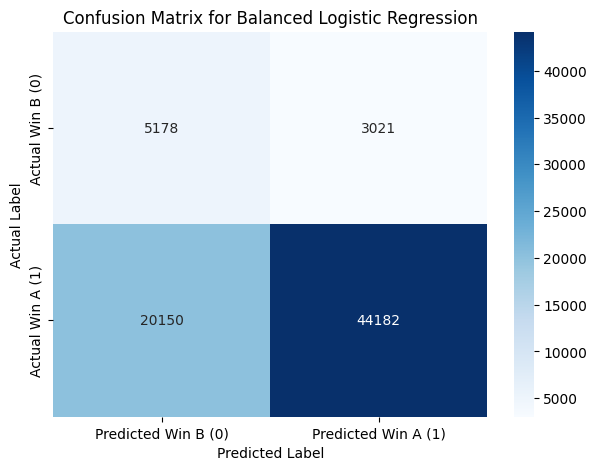

In [12]:
# Import necessary libraries if not already imported in the session
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported if X_test_scaled is DataFrame

# Check if required data exists
if 'X_train_scaled' in locals() and 'y_train' in locals() and \
   'X_test_scaled' in locals() and 'y_test' in locals():

    print("Training Logistic Regression model with class_weight='balanced'...")

    # 1. Initialize the model WITH class_weight='balanced'
    # This automatically adjusts weights inversely proportional to class frequencies
    log_reg_balanced_model = LogisticRegression(random_state=42, class_weight='balanced')

    # 2. Train the new model on the same scaled training data
    log_reg_balanced_model.fit(X_train_scaled, y_train)

    print("Balanced Logistic Regression model training complete!")
    # The new trained model is stored in 'log_reg_balanced_model'

    # --- Evaluate the NEW Balanced Model ---
    print("\nEvaluating the BALANCED Logistic Regression model on the test set...")

    # 3. Make Predictions with the balanced model
    y_pred_balanced = log_reg_balanced_model.predict(X_test_scaled)
    try:
      # Get probabilities for AUC
      y_pred_proba_balanced = log_reg_balanced_model.predict_proba(X_test_scaled)[:, 1]
      roc_auc_balanced = roc_auc_score(y_test, y_pred_proba_balanced)
    except Exception as e:
      print(f"Could not calculate predict_proba or ROC AUC score: {e}")
      y_pred_proba_balanced = None
      roc_auc_balanced = None

    # 4. Calculate Metrics for the balanced model
    accuracy_balanced = accuracy_score(y_test, y_pred_balanced)
    conf_matrix_balanced = confusion_matrix(y_test, y_pred_balanced)
    class_report_balanced = classification_report(y_test, y_pred_balanced, target_names=['Win B (0)', 'Win A (1)'])

    # 5. Print Metrics for the balanced model
    print(f"\n--- Results for Balanced Logistic Regression ---")
    print(f"Accuracy: {accuracy_balanced:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix_balanced)
    # TN | FP
    # FN | TP
    print("\nClassification Report:")
    print(class_report_balanced)
    if roc_auc_balanced is not None:
        print(f"\nArea Under ROC Curve (AUC-ROC): {roc_auc_balanced:.4f}")

    # 6. Visualize Confusion Matrix for the balanced model
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix_balanced, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Win B (0)', 'Predicted Win A (1)'],
                yticklabels=['Actual Win B (0)', 'Actual Win A (1)'])
    plt.yticks(va='center')
    plt.title('Confusion Matrix for Balanced Logistic Regression')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Error: Scaled training/test data not found. Please ensure previous steps ran successfully.")
    log_reg_balanced_model = None # Ensure model variable is None if training failed

### 4.3 Balanced Random Forest
A Random Forest Classifier, an ensemble learning method, is trained next. It also utilizes the `class_weight='balanced'` parameter to manage class imbalance and is explored for its potential to capture non-linear relationships in the data.

Starting Balanced Random Forest training & evaluation...
Training Random Forest model with class_weight='balanced'...
(This might take a bit longer than Logistic Regression...)
Balanced Random Forest model training complete!

Evaluating the BALANCED Random Forest model on the test set...

--- Results for Balanced Random Forest ---
Accuracy: 0.8853

Confusion Matrix:
[[ 1398  6801]
 [ 1519 62813]]

Classification Report:
              precision    recall  f1-score   support

   Win B (0)       0.48      0.17      0.25      8199
   Win A (1)       0.90      0.98      0.94     64332

    accuracy                           0.89     72531
   macro avg       0.69      0.57      0.59     72531
weighted avg       0.85      0.89      0.86     72531


Area Under ROC Curve (AUC-ROC): 0.7414


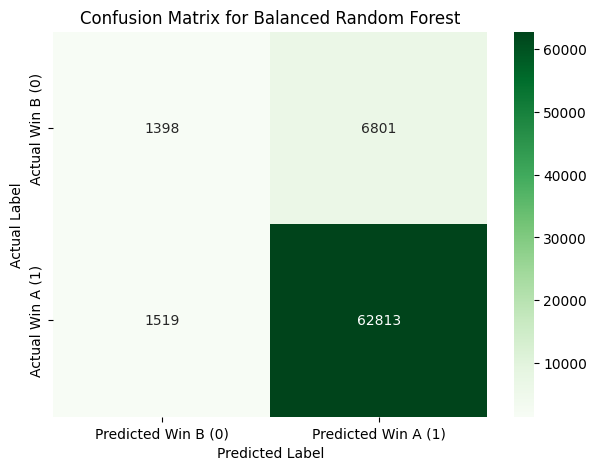

------------------------------


In [13]:
# --- Step 4.3.1: Train and Evaluate Balanced Random Forest ---
# (Ensure imports for RandomForestClassifier, metrics, seaborn, matplotlib, pandas are at the top of your notebook)

print("Starting Balanced Random Forest training & evaluation...")
if 'X_train_scaled' in locals() and 'y_train' in locals() and \
   'X_test_scaled' in locals() and 'y_test' in locals():

    # 1. Initialize the Random Forest model
    print("Training Random Forest model with class_weight='balanced'...")
    print("(This might take a bit longer than Logistic Regression...)")
    rf_balanced_model = RandomForestClassifier(n_estimators=100,
                                               random_state=42,
                                               class_weight='balanced',
                                               n_jobs=-1) # Uses all available CPU cores

    # 2. Train the new model
    rf_balanced_model.fit(X_train_scaled, y_train)
    print("Balanced Random Forest model training complete!")

    # 3. Make Predictions
    print("\nEvaluating the BALANCED Random Forest model on the test set...")
    y_pred_rf = rf_balanced_model.predict(X_test_scaled)
    try:
      y_pred_proba_rf = rf_balanced_model.predict_proba(X_test_scaled)[:, 1]
      roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
    except Exception as e:
      print(f"Could not calculate predict_proba or ROC AUC score for RF model: {e}")
      roc_auc_rf = None

    # 4. Calculate Metrics
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
    class_report_rf = classification_report(y_test, y_pred_rf, target_names=['Win B (0)', 'Win A (1)'])

    # 5. Print Metrics
    print(f"\n--- Results for Balanced Random Forest ---")
    print(f"Accuracy: {accuracy_rf:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix_rf)
    print("\nClassification Report:")
    print(class_report_rf)
    if roc_auc_rf is not None:
        print(f"\nArea Under ROC Curve (AUC-ROC): {roc_auc_rf:.4f}")

    # 6. Visualize Confusion Matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens', # Using 'Greens' for RF
                xticklabels=['Predicted Win B (0)', 'Predicted Win A (1)'],
                yticklabels=['Actual Win B (0)', 'Actual Win A (1)'])
    plt.yticks(va='center')
    plt.title('Confusion Matrix for Balanced Random Forest')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
else:
    print("Error: Scaled training/test data not found. Please ensure previous steps ran successfully.")
    rf_balanced_model = None # Ensure model variable is None if something failed before
print("-" * 30)

#### Feature Importances (Random Forest)
Examining the feature importances derived from the trained Random Forest model to understand which attributes contributed most to its predictions.

Calculating and plotting feature importances...


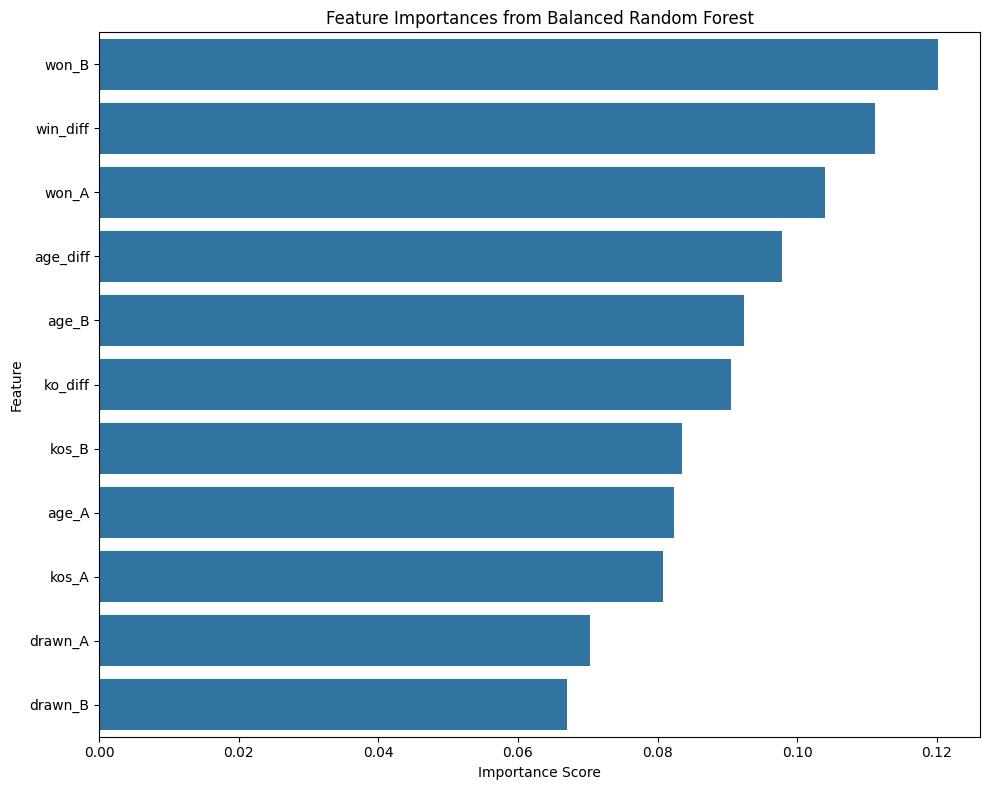


Top 10 Features by Importance:


,feature,importance
3,won_B,0.120206
9,win_diff,0.111140
2,won_A,0.103936
8,age_diff,0.097802
1,age_B,0.092364
10,ko_diff,0.090591
7,kos_B,0.083450
0,age_A,0.082340
6,kos_A,0.080852
4,drawn_A,0.070309


In [14]:
# Check if the Random Forest model exists
if 'rf_balanced_model' in locals() and rf_balanced_model is not None and \
   'X_train' in locals(): # Need X_train for feature names

    print("Calculating and plotting feature importances...")

    # Get feature importances
    importances = rf_balanced_model.feature_importances_
    feature_names = X_train.columns # Get feature names from the original X_train

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(10, 8)) # Adjust size as needed
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importances from Balanced Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Features by Importance:")
    display(feature_importance_df.head(10))

else:
    print("Error: Trained Random Forest model ('rf_balanced_model') or X_train not found.")

### 4.4 Balanced XGBoost (Selected Best Model)
Finally, an XGBoost Classifier is trained. XGBoost is a powerful gradient boosting algorithm known for its performance and efficiency. The `scale_pos_weight` parameter is used here to manage the class imbalance, calculated as the ratio of negative to positive class instances in the training data.

Preparing and Training XGBoost model...
Calculated scale_pos_weight: 0.1274
Training XGBoost model (this may take a moment)...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:53:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost model training complete!

Evaluating the XGBoost model on the test set...

--- Results for XGBoost (with scale_pos_weight) ---
Accuracy: 0.6937

Confusion Matrix:
[[ 5467  2732]
 [19486 44846]]

Classification Report:
              precision    recall  f1-score   support

   Win B (0)       0.22      0.67      0.33      8199
   Win A (1)       0.94      0.70      0.80     64332

    accuracy                           0.69     72531
   macro avg       0.58      0.68      0.57     72531
weighted avg       0.86      0.69      0.75     72531


Area Under ROC Curve (AUC-ROC): 0.7481


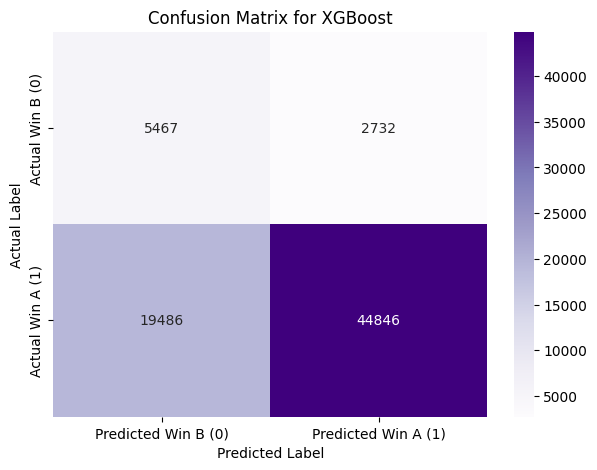

In [15]:
# Step 1: Ensure XGBoost is installed (optional, usually pre-installed)
# !pip install xgboost -q

import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Ensure pandas is imported
import numpy as np # Ensure numpy is imported

# Check if required data exists
if 'X_train_scaled' in locals() and 'y_train' in locals() and \
   'X_test_scaled' in locals() and 'y_test' in locals():

    print("Preparing and Training XGBoost model...")

    # Step 2: Calculate scale_pos_weight for imbalance handling
    # scale_pos_weight = count(negative class '0') / count(positive class '1')
    counts = np.bincount(y_train)
    if len(counts) == 2 and counts[1] != 0: # Ensure both classes exist and positive class count isn't zero
         scale_pos_weight = counts[0] / counts[1]
         print(f"Calculated scale_pos_weight: {scale_pos_weight:.4f}")
    else:
         print("Warning: Could not calculate valid scale_pos_weight from y_train.")
         print(f"y_train value counts: {pd.Series(y_train).value_counts()}") # Debug print
         scale_pos_weight = 1 # Default to 1 if calculation fails

    # Step 3: Initialize the XGBoost Classifier model
    xgb_model = xgb.XGBClassifier(
        objective='binary:logistic',    # Objective for binary classification
        scale_pos_weight=scale_pos_weight, # Handle class imbalance
        eval_metric='logloss',           # Evaluation metric for internal checks
        use_label_encoder=False,       # Recommended setting for newer XGBoost versions
        random_state=42,
        n_jobs=-1                      # Use all available CPU cores
    )

    # Step 4: Train the model
    print("Training XGBoost model (this may take a moment)...")
    xgb_model.fit(X_train_scaled, y_train)

    print("XGBoost model training complete!")

    # --- Evaluate the XGBoost Model ---
    print("\nEvaluating the XGBoost model on the test set...")

    # 5. Make Predictions
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    try:
      # Get probabilities for AUC
      y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
      roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
    except Exception as e:
      print(f"Could not calculate predict_proba or ROC AUC score: {e}")
      y_pred_proba_xgb = None
      roc_auc_xgb = None

    # 6. Calculate Metrics
    accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
    conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)
    class_report_xgb = classification_report(y_test, y_pred_xgb, target_names=['Win B (0)', 'Win A (1)'])

    # 7. Print Metrics
    print(f"\n--- Results for XGBoost (with scale_pos_weight) ---")
    print(f"Accuracy: {accuracy_xgb:.4f}")
    print("\nConfusion Matrix:")
    print(conf_matrix_xgb)
    # TN | FP
    # FN | TP
    print("\nClassification Report:")
    print(class_report_xgb)
    if roc_auc_xgb is not None:
        print(f"\nArea Under ROC Curve (AUC-ROC): {roc_auc_xgb:.4f}")

    # 8. Visualize Confusion Matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Purples', # Changed color map
                xticklabels=['Predicted Win B (0)', 'Predicted Win A (1)'],
                yticklabels=['Actual Win B (0)', 'Actual Win A (1)'])
    plt.yticks(va='center')
    plt.title('Confusion Matrix for XGBoost')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Error: Scaled training/test data not found. Please ensure previous steps ran successfully.")
    xgb_model = None # Ensure model variable is None if something failed before

#### Feature Importances (XGBoost)
To understand what drove the predictions of the best-performing model, feature importances from the balanced XGBoost classifier are examined.

Calculating and plotting feature importances for XGBoost model...


<ipython-input-16-1c14b49302d9>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df_xgb, palette='viridis') # Example color palette


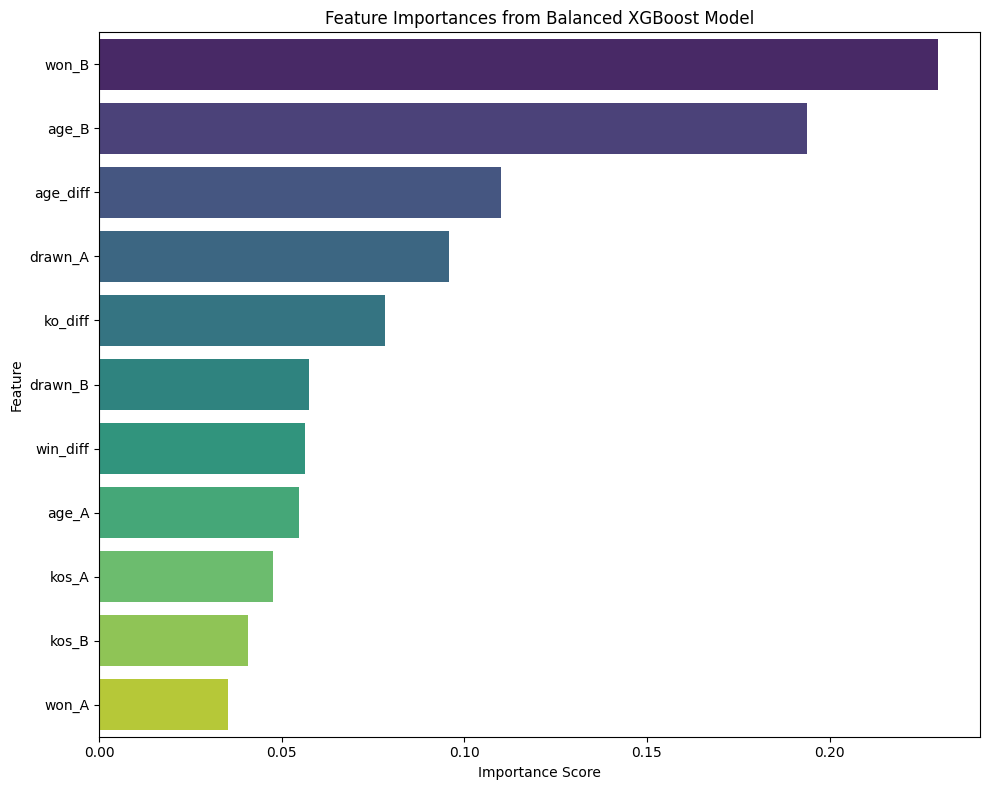


Top 10 Features by Importance (XGBoost):


,feature,importance
3,won_B,0.229710
1,age_B,0.193867
8,age_diff,0.110079
4,drawn_A,0.095728
10,ko_diff,0.078362
5,drawn_B,0.057482
9,win_diff,0.056396
0,age_A,0.054712
6,kos_A,0.047597
7,kos_B,0.040814


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np # Ensure numpy is imported

# Check if the XGBoost model and training data (for column names) exist
if 'xgb_model' in locals() and xgb_model is not None and \
   'X_train' in locals(): # Using X_train column names, assuming they match X_train_scaled

    print("Calculating and plotting feature importances for XGBoost model...")

    # Get feature importances from the trained XGBoost model
    try:
        importances = xgb_model.feature_importances_
        feature_names = X_train.columns # Get feature names from X_train

        # Create a DataFrame for visualization
        feature_importance_df_xgb = pd.DataFrame({'feature': feature_names, 'importance': importances})

        # Sort features by importance
        feature_importance_df_xgb = feature_importance_df_xgb.sort_values(by='importance', ascending=False)

        # Plot feature importances
        plt.figure(figsize=(10, 8)) # You might adjust the size depending on the number of features
        sns.barplot(x='importance', y='feature', data=feature_importance_df_xgb, palette='viridis') # Example color palette
        plt.title('Feature Importances from Balanced XGBoost Model')
        plt.xlabel('Importance Score') # XGBoost default is often 'weight' or 'gain' based
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        # Print the top features numerically
        print("\nTop 10 Features by Importance (XGBoost):")
        display(feature_importance_df_xgb.head(10))

    except AttributeError:
        print("Error: Could not get feature importances. Was the model trained correctly?")
    except Exception as e:
        print(f"An error occurred: {e}")

else:
    print("Error: Trained XGBoost model ('xgb_model') or X_train (for feature names) not found.")

## 5. Notebook Conclusion

This notebook successfully prepared the original `boxing_matches.csv` dataset for a binary classification task (predicting 'Win A' vs. 'Win B') by capping outliers, engineering a binary target, selecting and engineering relevant pre-fight features, and imputing missing values.
Several models were trained and evaluated, with a focus on addressing significant class imbalance. The balanced XGBoost classifier, utilizing `scale_pos_weight`, yielded the best performance with an AUC-ROC score of approximately 0.748 and the highest F1-score (0.33) and Recall (0.67) for the minority 'Win B' class.
Feature importance analysis from this XGBoost model highlighted opponent's pre-fight win record (`won_B`), opponent's age (`age_B`), and the age difference between fighters (`age_diff`) as key predictive factors.